In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os, sys, re, gc, glob
from tqdm.auto import tqdm, trange
from utils import JDIDataset, JDIModel, get_grey_image, assign_labels



import seaborn as sns

2021-03-05 12:08:02,971 - INFO - dataset:dataset.py:24 - dataset package is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
model = torch.load('model/model.weights').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=557, out_features=64, bias=False)
  (batchNorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (hidden1): Linear(in_features=64, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (hidden2): Linear(in_features=32, out_features=21, bias=True)
)

## Load test dataset

In [4]:
# dataset_name = 'angular'
# dataset_name = 'html-5'
dataset_name = 'react-ant'
dataset_name = 'mobile-and-html-5'
# dataset_name = 'bootstrap'
# dataset_name = 'dummy'
dataset_name = 'google'
# dataset_name = 'cnews'

In [5]:
dataset = JDIDataset(dataset_names=[dataset_name], rebalance=False)

2021-03-05 12:08:04,277 - INFO - dataset:dataset.py:306 - Dataset for google
2021-03-05 12:08:04,322 - INFO - dataset:dataset.py:308 - Dataset shape: (197, 23)
2021-03-05 12:08:04,323 - INFO - dataset:dataset.py:310 - cleaning tag_name from dummy words
2021-03-05 12:08:04,324 - WARNING - dataset:dataset.py:319 - LABELS: not loaded
2021-03-05 12:08:04,325 - INFO - dataset:dataset.py:52 - select all leafs (nodes which are not parents)
2021-03-05 12:08:04,325 - INFO - dataset:dataset.py:54 - Leafs set size: 113 (nodes which have no children)
2021-03-05 12:08:04,326 - INFO - dataset:dataset.py:57 - count number of references to leafs
2021-03-05 12:08:04,327 - INFO - dataset:dataset.py:59 - Nodes with leafs as children set size: 57 (nodes which have leafs as children)
2021-03-05 12:08:04,329 - INFO - dataset:dataset.py:62 - count num children for each node
2021-03-05 12:08:04,329 - INFO - dataset:dataset.py:64 - Nodes with children: 85
2021-03-05 12:08:04,330 - INFO - dataset:dataset.py:67 

In [6]:
dataset.dataset.shape

(197, 33)

In [7]:
dataset.dataset_copy_df[['label_text', 'label']]

,label_text,label
0,n/a,-1.0
1,n/a,-1.0
2,n/a,-1.0
3,n/a,-1.0
4,n/a,-1.0
...,...,...
192,n/a,-1.0
193,n/a,-1.0
194,n/a,-1.0
195,n/a,-1.0


In [8]:
dataset.labels_text

,label_text
0,n/a
1,n/a
2,n/a
3,n/a
4,n/a
...,...
192,n/a
193,n/a
194,n/a
195,n/a


In [9]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1)

In [10]:
with open('model/label_ohe.pkl', 'rb') as f:
    label_ohe = pickle.load(f)

results = []
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = torch.round(torch.nn.Softmax(dim=1)(model(x.to(DEVICE)).to('cpu'))).detach().numpy()
            #print(y_pred)
            
            y_true_label = label_ohe.inverse_transform(y).squeeze().squeeze()
            try:
                y_pred_label = label_ohe.inverse_transform(y_pred).squeeze().squeeze()
            except:
                y_pred_label = 'n/a'
            
            # print(y_pred, y_pred_label, y_true_label)
            
            results.append({
                'y_true': np.argmax(y).item(),
                'y_pred': np.argmax(y_pred),
                'y_true_label': y_true_label, 
                'y_pred_label': y_pred_label
            })
            bar.update(1)

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/197 [00:00<?, ?it/s]

,y_true,y_pred,y_true_label,y_pred_label
0,12,12,n/a,n/a
1,12,12,n/a,n/a
2,12,12,n/a,n/a
3,12,12,n/a,n/a
4,12,12,n/a,n/a
...,...,...,...,...
192,12,12,n/a,n/a
193,12,12,n/a,n/a
194,12,12,n/a,n/a
195,12,12,n/a,n/a


In [11]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=results_df.y_true.values,
                     y_pred=results_df.y_pred.values, 
                     labels=[i for i, e in enumerate(label_ohe.categories_[0])]
                    ), 
    columns=label_ohe.categories_[0],
    index=label_ohe.categories_[0]
)



In [12]:
confusion_matrix_df

,button,checkbox,checklist,colorpicker,datetimeselector,dropdown,dropdownselector,fileinput,iframe,image,...,link,n/a,numberselector,progressbar,radiobutton,range,table,text,textarea,textfield
button,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checklist,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
colorpicker,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
datetimeselector,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdownselector,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fileinput,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
image,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
import seaborn as sns


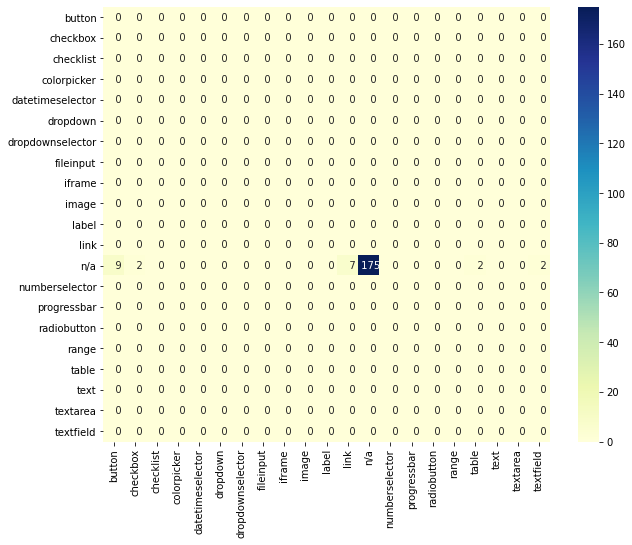

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu");

In [15]:
dataset_name

'google'

In [16]:
with open('dataset/classes.txt', "r") as f:
    classes = [ l.strip() for l in f.readlines()]
classes

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox',
 'textarea',
 'label',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'radiobutton',
 'table',
 'n/a']

In [17]:
dataset.dataset_copy_df.label_text
dataset.dataset_copy_df['label_text_predicted'] = results_df.y_pred_label
dataset.dataset_copy_df[['label_text', 'label_text_predicted']]

,label_text,label_text_predicted
0,n/a,n/a
1,n/a,n/a
2,n/a,n/a
3,n/a,n/a
4,n/a,n/a
...,...,...
192,n/a,n/a
193,n/a,n/a
194,n/a,n/a
195,n/a,n/a


(600, 800)


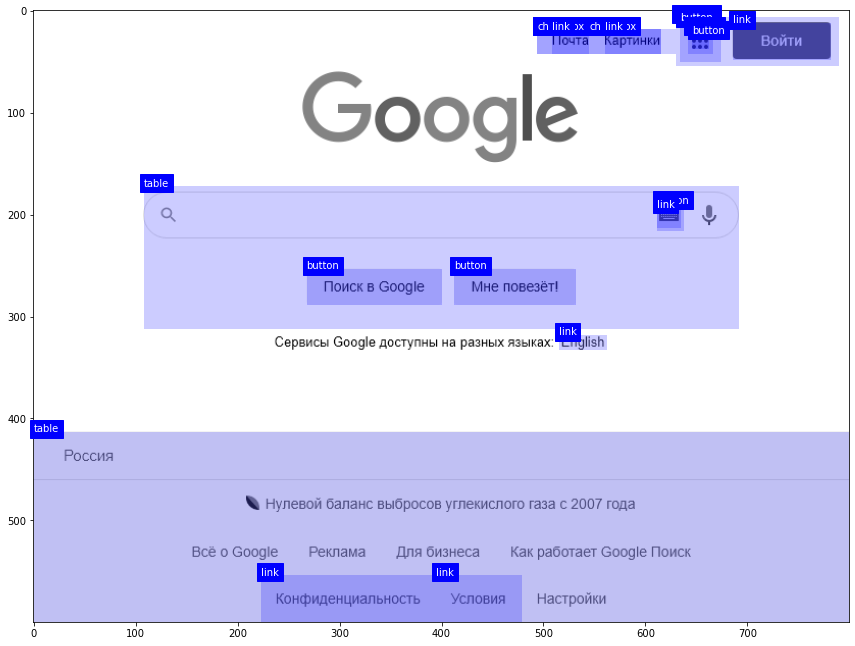

In [18]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset_copy_df[dataset.dataset_copy_df.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted, color='white', backgroundcolor='blue')

for i, r in dataset.dataset_copy_df[dataset.dataset_copy_df.label != -1].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, r.label_text, color='white', backgroundcolor='red')
    




In [19]:
results_df

,y_true,y_pred,y_true_label,y_pred_label
0,12,12,n/a,n/a
1,12,12,n/a,n/a
2,12,12,n/a,n/a
3,12,12,n/a,n/a
4,12,12,n/a,n/a
...,...,...,...,...
192,12,12,n/a,n/a
193,12,12,n/a,n/a
194,12,12,n/a,n/a
195,12,12,n/a,n/a
